In [238]:
# Import packages
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit


# Pacakges for dimensional reduction procedure
from sklearn.decomposition import PCA
from ZIFA import ZIFA
from ZIFA import block_ZIFA

# Pacakges for different clustering method
# Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering
# K Means
from sklearn.cluster import KMeans
# KNN
from sklearn.neighbors import NearestNeighbors
# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture

from sklearn.metrics import accuracy_score


# Set random seed
import random
random.seed(25)

## Data Import and Pre-process

In [19]:
# Import data from rds file
count = pyreadr.read_r('../Data/Tcell_5type_filtered.rds')
count = count[None]
label = pyreadr.read_r('../Data/Tcell_5type_filtered_labels.rds')
label = label[None]

In [31]:
# Extract the read count array
count_array = count.to_numpy()

In [151]:
count_array

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 1., ..., 0., 1., 2.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [195]:
# Change labels to integer
new_cluster = dict(zip(list(set(label['Group'])), list(range(5))))
new_label = []
for k in range(len(list(label['Group']))):
    old_label = list(label['Group'])[k]
    new_label.append(new_cluster[old_label])

## PCA

In [35]:
# Implement PCA
pca = PCA(n_components=50)
count_array_pca = pca.fit_transform(np.transpose(count_array))

In [36]:
# Check the dim of the array after PCA transformation
count_array_pca.shape

(2989, 50)

## ZIFA

In [42]:
# compute the log count array by log2(1 + count_data)
log_count_array = np.log(1 + count_array)

In [43]:
count_array_ZIFA, model_params = block_ZIFA.fitModel(np.transpose(log_count_array), 50, p0_thresh=0.9)

Filtering out all genes which are zero in more than 90.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 6
Running block zero-inflated factor analysis with N = 2989, D = 3385, K = 50, n_blocks = 6
Block sizes [564, 564, 564, 564, 564, 565]


In [45]:
# Store the array to avoid multiple running and save time
# Since it takes more than 40 mins to run this procedure, I save the result to a csv file for convenience.
pd.DataFrame(count_array_ZIFA).to_csv("count_array_ZIFA.csv")

In [44]:
# Check the dim of the array after ZIFA transformation
count_array_ZIFA.shape

(2989, 50)

## Hierarchical Clustering

In [239]:
start = timeit.default_timer()

# Hierarchical Clustering on PCA array
hc_pca = AgglomerativeClustering(n_clusters=5).fit(count_array_pca)
# Obtain Predicted labels
hc_pca_pred = hc_pca.labels_

stop = timeit.default_timer()
# Record Run time
hc_pca_time = stop - start

In [241]:
start = timeit.default_timer()

# Hierarchical Clustering on ZIFA array
hc_ZIFA = AgglomerativeClustering(n_clusters=5).fit(count_array_ZIFA)
# Obtain Predicted labels
hc_ZIFA_pred = hc_ZIFA.labels_

stop = timeit.default_timer()
# Record Run time
hc_ZIFA_time = stop - start

## K Means

In [242]:
start = timeit.default_timer()

# K Means on PCA array
kmeans_pca = KMeans(n_clusters=5, random_state=0).fit(count_array_pca)
# Obtain Predicted labels
kmeans_pca_pred = kmeans_pca.labels_

stop = timeit.default_timer()
# Record Run time
kmeans_pca_time = stop - start

In [243]:
start = timeit.default_timer()

# K Means on ZIFA array
kmeans_ZIFA = KMeans(n_clusters=5, random_state=0).fit(count_array_ZIFA)
# Obtain Predicted labels
kmeans_ZIFA_pred = kmeans_ZIFA.labels_

stop = timeit.default_timer()
# Record Run time
kmeans_ZIFA_time = stop - start

## KNN

In [119]:
def gather_neighbors(tree):
    """
    This function is used to gather neigbors which is the output from TreeBall algorithm and 
    make them in the same cluster.
    """
    tree_list = list(tree)
    cluster = []
    i = len(tree_list)
    while(len(tree_list) > 0):
        cluster.append(np.array(tree_list[-1]))
        n_old = 0
        n_new = len(tree_list)
        while (n_old != n_new):
            # When no update in tree_list, which means that the union of neighborhoods based on the initial 
            # neighborhood is complete. Then break the inner while loop and initialize with a new neighborhood.
            for j in range(n_new - 1, -1, -1):
                # Use for loop to determine if two neighborhoods share same data points, union them.
                if len(set(tree_list[j]).intersection(set(cluster[-1]))) > 0:
                    cluster[-1] = np.array(list(set(tree_list[j]).union(set(cluster[-1]))))
                    tree_list.pop(j)
            n_old = n_new
            n_new = len(tree_list)
        
    return cluster

In [245]:
start = timeit.default_timer()

# KNN on PCA array
neigh = NearestNeighbors(n_neighbors=3)
neigh.fit(count_array_pca)
a = neigh.kneighbors(count_array_pca, return_distance=False)
cluster_pca = gather_neighbors(a)
len(cluster_pca)

2

In [246]:
# Obtain Predicted labels
knn_pca = np.zeros(count_array_pca.shape[0])
for i in range(len(cluster_pca)):
    for j in cluster_pca[i]:
        knn_pca[j] = i
knn_pca

stop = timeit.default_timer()
# Record Run time
knn_pca_time = stop - start

In [247]:
start = timeit.default_timer()

# KNN on PCA array
neigh = NearestNeighbors(n_neighbors=3)
neigh.fit(count_array_ZIFA)
b = neigh.kneighbors(count_array_ZIFA, return_distance=False)
cluster_ZIFA = gather_neighbors(b)
len(cluster_ZIFA)

6

In [248]:
# Obtain Predicted labels
knn_ZIFA = np.zeros(count_array_ZIFA.shape[0])
for i in range(len(cluster_ZIFA)):
    for j in cluster_ZIFA[i]:
        knn_ZIFA[j] = i

stop = timeit.default_timer()
# Record Run time
knn_ZIFA_time = stop - start

## Gaussian Mixure Model

In [252]:
start = timeit.default_timer()

# Gaussian Mixure Model on PCA array
gm_pca = GaussianMixture(n_components=5, random_state=0).fit(count_array_pca)
# Obtain Predicted labels
gm_pca_pred = gm_pca.predict(count_array_pca)

stop = timeit.default_timer()
# Record Run time
gm_pca_time = stop - start

In [253]:
start = timeit.default_timer()

# Gaussian Mixure Model on ZIFA array
gm_ZIFA = GaussianMixture(n_components=5, random_state=0).fit(count_array_ZIFA)
# Obtain Predicted labels
gm_ZIFA_pred = gm_ZIFA.predict(count_array_ZIFA)

stop = timeit.default_timer()
# Record Run time
gm_ZIFA_time = stop - start

## Compute Accuracy and Generate Plots

In [211]:
def assign_label(pred, label):
    """
    This function is used to assign label of clusters in pred by the majority of cells in it.
    """
    new_cluster = []
    for i in range(len(set(pred))):
        indexes = [j for j,x in enumerate(pred) if x == i]
        counts = np.bincount(label[indexes]) 
        new_cluster.append(np.argmax(counts))
    new_label = []
    for k in range(len(pred)):
        old_label = pred[k]
        new_label.append(new_cluster[old_label])
    return new_label

In [218]:
# Assign new labels to clusters using hierarchical clustering on PCA data
hc_pca_pred2 = assign_label(np.array(hc_pca_pred), np.array(new_label))
# accuracy for test data using hierarchical clustering on PCA data
hc_pca_acc = accuracy_score(np.array(new_label), np.array(hc_pca_pred2))

In [222]:
# Assign new labels to clusters using hierarchical clustering on ZIFA data
hc_ZIFA_pred2 = assign_label(np.array(hc_ZIFA_pred), np.array(new_label))
# accuracy for test data using hierarchical clustering on ZIFA data
hc_ZIFA_acc = accuracy_score(np.array(new_label), np.array(hc_ZIFA_pred2))

In [223]:
# Assign new labels to clusters using K means on PCA data
kmeans_pca_pred2 = assign_label(np.array(kmeans_pca_pred), np.array(new_label))
# accuracy for test data using K means on PCA data
kmeans_pca_acc = accuracy_score(np.array(new_label), np.array(kmeans_pca_pred2))

In [224]:
# Assign new labels to clusters using K means on ZIFA data
kmeans_ZIFA_pred2 = assign_label(np.array(kmeans_ZIFA_pred), np.array(new_label))
# accuracy for test data using K means on ZIFA data
kmeans_ZIFA_acc = accuracy_score(np.array(new_label), np.array(kmeans_ZIFA_pred2))

In [226]:
# Assign new labels to clusters using KNN on PCA data
knn_pca2 = assign_label(np.array(knn_pca).astype('int8'), np.array(new_label))
# accuracy for test data using KNN on PCA data
knn_pca_acc = accuracy_score(np.array(new_label), np.array(knn_pca2).astype('int8'))

In [227]:
# Assign new labels to clusters using KNN on ZIFA data
knn_ZIFA2 = assign_label(np.array(knn_ZIFA).astype('int8'), np.array(new_label))
# accuracy for test data using KNN on ZIFA data
knn_ZIFA_acc = accuracy_score(np.array(new_label), np.array(knn_ZIFA2).astype('int8'))

In [231]:
# Assign new labels to clusters using GMM on PCA data
gm_pca_pred2 = assign_label(np.array(gm_pca_pred), np.array(new_label))
# accuracy for test data using GMM on PCA data
gm_pca_acc = accuracy_score(np.array(new_label), np.array(gm_pca_pred2))

In [232]:
# Assign new labels to clusters using GMM on ZIFA data
gm_ZIFA_pred2 = assign_label(np.array(gm_ZIFA_pred), np.array(new_label))
# accuracy for test data using GMM on ZIFA data
gm_ZIFA_acc = accuracy_score(np.array(new_label), np.array(gm_ZIFA_pred2))

<AxesSubplot:title={'center':'Bar Chart of Accuracy Score Across Different Algrothms by PCA or ZIFA Transformation'}, xlabel='Algorithm'>

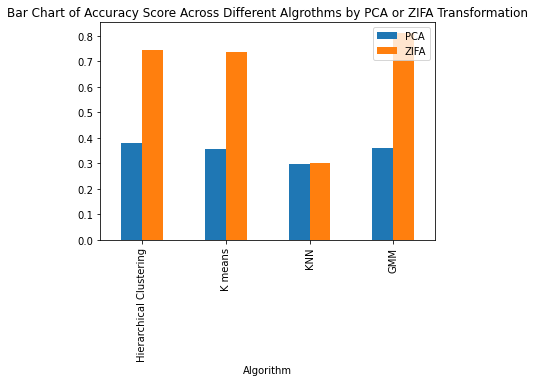

In [236]:
# Generate Dataframe for plotting
df = pd.DataFrame([['Hierarchical Clustering', hc_pca_acc, hc_ZIFA_acc], 
                   ['K means', kmeans_pca_acc, kmeans_ZIFA_acc],
                   ['KNN', knn_pca_acc, knn_ZIFA_acc], 
                   ['GMM', gm_pca_acc, gm_ZIFA_acc]],
                  columns=['Algorithm', 'PCA', 'ZIFA'])
# Plot grouped bar chart for Figure 1
df.plot(x='Algorithm',
        kind='bar',
        stacked=False,
        title='Bar Chart of Accuracy Score Across Different Algrothms by PCA or ZIFA Transformation')



<AxesSubplot:title={'center':'Bar Chart of Run Time Across Different Algrothms by PCA or ZIFA Transformation'}, xlabel='Algorithm'>

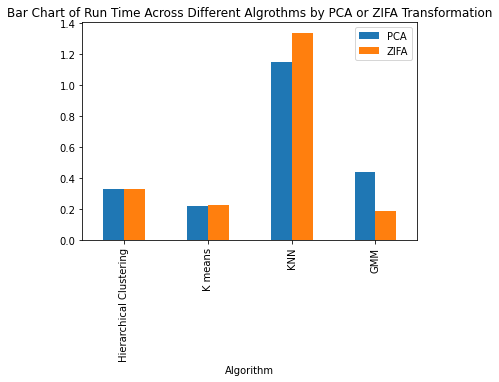

In [254]:
# Generate Dataframe for plotting
df = pd.DataFrame([['Hierarchical Clustering', hc_pca_time, hc_ZIFA_time], 
                   ['K means', kmeans_pca_time, kmeans_ZIFA_time],
                   ['KNN', knn_pca_time, knn_ZIFA_time], 
                   ['GMM', gm_pca_time, gm_ZIFA_time]],
                  columns=['Algorithm', 'PCA', 'ZIFA'])

# Plot grouped bar chart for Figure 2
df.plot(x='Algorithm',
        kind='bar',
        stacked=False,
        title='Bar Chart of Run Time Across Different Algrothms by PCA or ZIFA Transformation')
